Loading Conditions

1. Wing (Horizontal)
- a. Distributed Load (Lift)
- b. Weight of entire plane in middle of beam (overestimate)

2. Wing (Vertical)
- a. Pinned supports at motor locations
- b. Weight of entire plane in middle of beam (overestimate)

3. Wing to Tail (1.4m)
- a. Cantilever beam with weight of tail at end + pitching moment (1Nm for now, make it variable)

4. Motor to Motor 
- a. Pinned at motor locations
- b. Weight of plane

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import pandas as pd
import scipy.integrate as integrate
from operator import add

$$Lift = C_l \frac{1}{2}\rho v^2 A $$

In [57]:
rho = 1.225 # kg/m^3
v = 18 # m/s

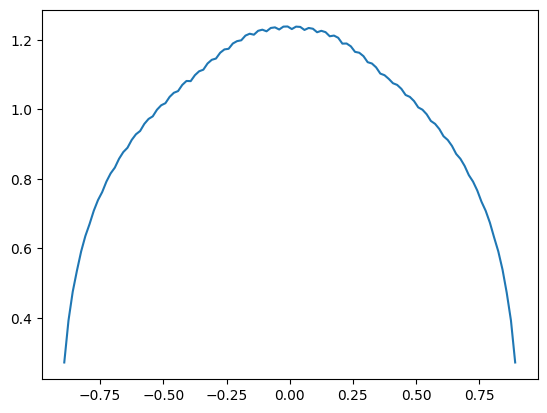

In [58]:
df = pd.read_csv('Book1.csv')
df['area'] = df['del_y']*df['Chord']
df['lift'] = df['area']*df['cl']*0.5*rho*v**2
plt.plot(df['y_span'],df['lift'])

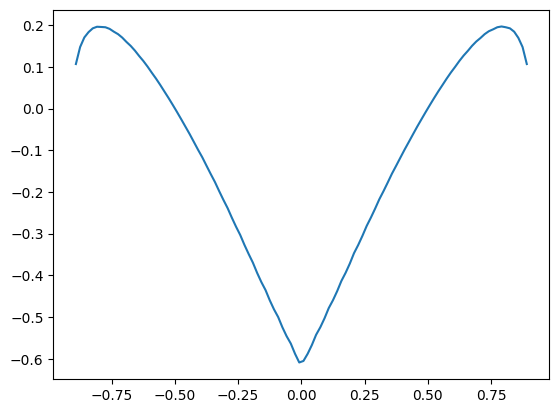

In [59]:
wing = pd.DataFrame()
wing['y_span'] = df['y_span']
wing['lift'] = df['lift']
pin_a = -0.5
pin_b = 0.5
moment1a = []

for index, row in wing.iterrows():
    if row['y_span'] < pin_a: # to left of pin a
        moment1a.append(-row['lift']*(row['y_span']-pin_a))
    elif row['y_span'] > pin_a and row['y_span'] < 0: # between pin a and center
        moment1a.append(-row['lift']*((row['y_span']-pin_a)))
    elif row['y_span'] > 0 and row['y_span'] < pin_b: # between center and pin b
        moment1a.append(-row['lift']*(pin_b-(row['y_span']))) 
    else: #to the right of pin b
           moment1a.append(-row['lift']*(pin_b-(row['y_span'])))


plt.plot(wing['y_span'],moment1a)


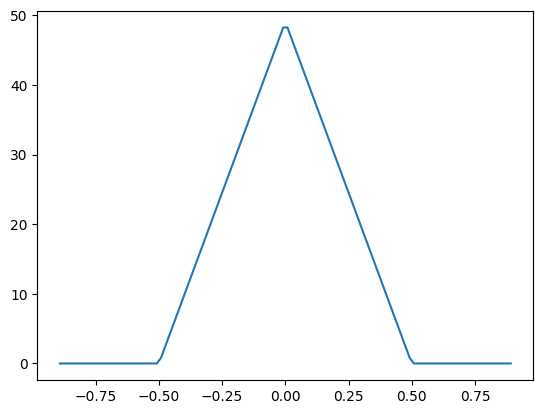

In [60]:
plane_mass = 10         #kg
W = plane_mass * 9.81   # weight in N acting in middle of wing spar
moment1b = []



for index, row in wing.iterrows():
    if row['y_span'] < pin_a: # to left of pin a
        moment1b.append(0)
    elif row['y_span'] > pin_a and row['y_span'] < 0: # between pin a and center
        moment1b.append(W * (row['y_span']-pin_a))
    elif row['y_span'] > 0 and row['y_span'] < pin_b: # between center and pin b
        moment1b.append(W * (pin_b-row['y_span'])) 
    else: #to the right of pin b
        moment1b.append(0)


plt.plot(wing['y_span'],moment1b)

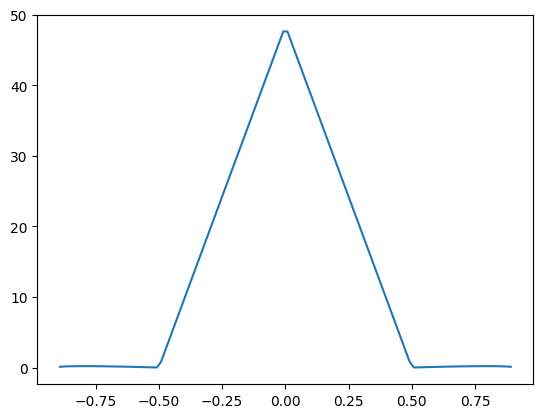

In [61]:
moment1 = list(map(add, moment1a, moment1b))

plt.plot(wing['y_span'],moment1)

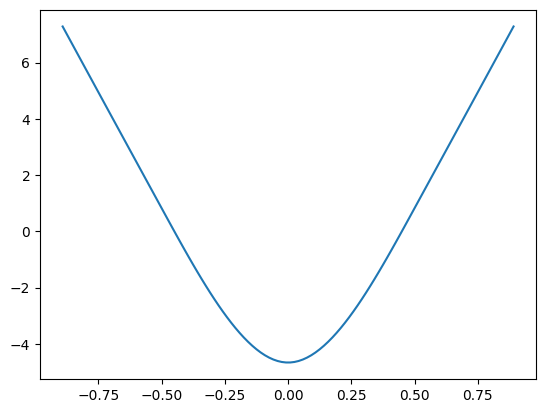

In [62]:


theta = integrate.cumulative_trapezoid(moment1,wing['y_span'],initial = 0)
theta = integrate.cumulative_trapezoid(moment1, wing['y_span'], initial=0)
theta -= np.median(theta)
#plt.plot(wing['y_span'], theta,label = 'theta')
displacement1 = integrate.cumulative_trapezoid(theta, wing['y_span'], initial=0)
displacement1 -= np.median(displacement1)
#plt.plot(wing['y_span'], displacement1,label = 'displacement')

E = 33          # msi
ID = 0.75    # inch
OD = 0.83   # inch
I = ((np.pi)/64) * ((OD*0.0254)**4-(ID*0.0254)**4)  # m^4

displacement1_scaled = []

for x in displacement1:
    displacement1_scaled.append((x/((E*6.8948*10**9)*I))*1000)

plt.plot(wing['y_span'], displacement1_scaled,label = 'displacement')


In [63]:
d1_max = max(displacement1_scaled) # max displacement of wing spar in mm
print(d1_max, "mm")

7.283646904796863 mm


In [64]:
moment1_max = max(moment1, key=abs)                 #N*m

stress1_max = ((moment1_max * ((OD*0.0254)/2)) / I) * 10**-6  #MPa

print(stress1_max, "MPa")

155.35258818423063 MPa
